In [4]:
# === MOUNT GOOGLE DRIVE === ( connecting google drive and collab)
from google.colab import drive
drive.mount('/content/drive')

# === IMPORT LIBRARIES ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split #for splitting the data into training and validation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import xgboost as xgb #For training a gradient boosting model (XGBoost)

# === LOAD DATASET FROM GOOGLE DRIVE ===
# Update this path if your file is inside a folder
data_path = '/content/drive/My Drive/Academic Files/bank-additional.csv' # REPLACE WITH YOUR ACTUAL FILE PATH
data = pd.read_csv(data_path, sep=';')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# === DATA CLEANING ===
data['y'] = data['y'].map({'yes': 1, 'no': 0})
data.drop(columns=['duration'], inplace=True) # dropping the duration column
data.dropna(inplace=True)  #deleting row with missing value

In [6]:
# Convert categorical columns to dummy variables (converts categorical columns into numerical format using one-hot encoding)
categorical_cols = ["job", "marital", "education", "default", "housing", "loan",
                    "contact", "month", "day_of_week", "poutcome"]
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [7]:
# === SPLIT FEATURES AND TARGET === 80% on training and 20% on testing
X = data.drop(columns='y')
y = data['y']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

In [8]:
# === SCALE AND APPLY PCA ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [9]:
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

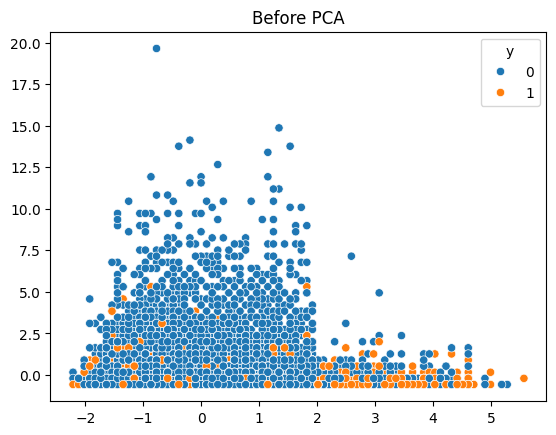

In [10]:
# === PLOTS ===
sns.scatterplot(x=X_train_scaled[:, 0], y=X_train_scaled[:, 1], hue=y_train)
plt.title("Before PCA")
plt.show()

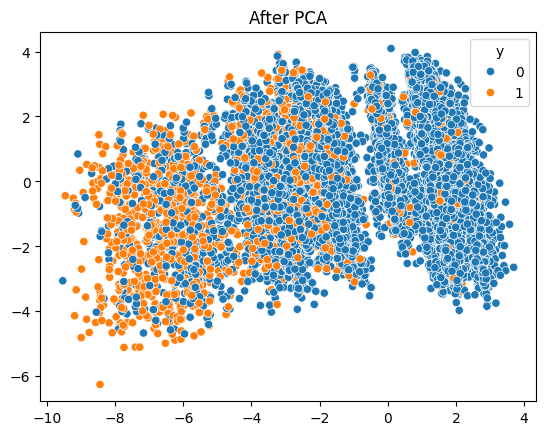

In [11]:

sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.title("After PCA")
plt.show()

In [14]:
# === ANN MODEL ===
ann_model = Sequential()
ann_model.add(Dense(6, input_dim=X_train_pca.shape[1], activation='relu'))
ann_model.add(Dense(1, activation='sigmoid'))
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train_pca, y_train, epochs=10, batch_size=16, verbose=1)


y_pred_ann = (ann_model.predict(X_val_pca) > 0.3).astype(int)

Epoch 1/10
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7940 - loss: 0.4856
Epoch 2/10
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8966 - loss: 0.2919
Epoch 3/10
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8974 - loss: 0.2902
Epoch 4/10
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9002 - loss: 0.2818
Epoch 5/10
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8960 - loss: 0.2894
Epoch 6/10
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8996 - loss: 0.2819
Epoch 7/10
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8969 - loss: 0.2864
Epoch 8/10
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8999 - loss: 0.2762
Epoch 9/10
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8995 - loss: 0.2803
Epoch 10/10
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8985 - loss: 0.2844
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [15]:
# === GBM MODEL (XGBoost) ===
xgb_model = xgb.XGBClassifier(n_estimators=850, max_depth=9, learning_rate=0.8,
                              use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_gbm = (xgb_model.predict_proba(X_val)[:, 1] > 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:12:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [16]:
# === EVALUATION FUNCTION ===
def evaluate_model(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {model_name} ===")
    print("Confusion Matrix:\n", cm)
    print("Accuracy:", round(acc, 4))

evaluate_model(y_val, y_pred_ann, "Neural Network")
evaluate_model(y_val, y_pred_gbm, "Gradient Boosting")


=== Neural Network ===
Confusion Matrix:
 [[6722  576]
 [ 486  454]]
Accuracy: 0.8711

=== Gradient Boosting ===
Confusion Matrix:
 [[6916  382]
 [ 635  305]]
Accuracy: 0.8765
